# Import libraries

In [1]:
'''#import libraries
%matplotlib widget
import trackpy as tp
tp.quiet()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

import sdt
from sdt import io, multicolor, brightness, roi
from mpl_toolkits.mplot3d import Axes3D
import scipy.io
import pims
from scipy.ndimage import gaussian_filter
import matplotlib.patches as patches
from glob import glob
import copy
from sdt import nbui, io
import traitlets
import ipywidgets
import itertools'''

'#import libraries\n%matplotlib widget\nimport trackpy as tp\ntp.quiet()\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport numpy as np\nfrom mpl_toolkits.mplot3d import Axes3D\nimport matplotlib as mpl\n\nimport sdt\nfrom sdt import io, multicolor, brightness, roi\nfrom mpl_toolkits.mplot3d import Axes3D\nimport scipy.io\nimport pims\nfrom scipy.ndimage import gaussian_filter\nimport matplotlib.patches as patches\nfrom glob import glob\nimport copy\nfrom sdt import nbui, io\nimport traitlets\nimport ipywidgets\nimport itertools'

In [2]:
#import libraries
%matplotlib widget
from glob import glob
import pims
import matplotlib.pyplot as plt
import sdt
from sdt import nbui, roi, multicolor, image 
import math

import ipywidgets
import os
import numpy as np
import pandas as pd
import pickle
from tifffile import TiffFile, TiffWriter
import re
from scipy.io import loadmat # to load matlab .mat files



# Import STORM video

## input (specify folder path)

In [3]:
# Define the directory where files are stored
directory = os.getcwd()

# Define the regex pattern
pattern = re.compile(r'def[0-9]+_n1[0-9]+\.mat')

# List all files in the directory
files = os.listdir(directory)

# Filter files that match the pattern
matching_files = [f for f in files if pattern.match(f)]
matching_files.sort()

matching_paths = [directory+'/'+f for f in matching_files]
# Output the list of matching filenames
print(matching_files)
print(matching_paths)


#import storm videos (tif)
pth = directory
filenames = sorted(glob(f"{pth}/*.stk"))
filenames = [filenames[0]]
print(filenames)

['def600_n133.mat']
['/mnt/d/Simon Jaritz/mlefitgpu-main/def600_n133.mat']
['/mnt/d/Simon Jaritz/mlefitgpu-main/2023_02_16_Nr1_ROI1_STORM_1_RICMdSTORMred.stk']


In [4]:
def crop(img, x, y, size):
    return img[x:x+size, y:y+size]

def imchange(change=None):
    loc_r_ui.input = loc_r_imsel.output
    
def imchange(change=None):
    loc_rb_ui.input = loc_rb_imsel.output
    
def imchangeb(change=None):
    loc_bb_ui.input = loc_bb_imsel.output

In [5]:
# open images using tifffile
vid = [pims.open("out.tif")]

# ROI management and bead input

In [6]:
#define roi
roiv = roi.ROI((128,256), size=(256, 256)) 
# (128, 0) for red channel, (128, 256) for green channel


# crop
vid=[roiv(i) for i in vid]

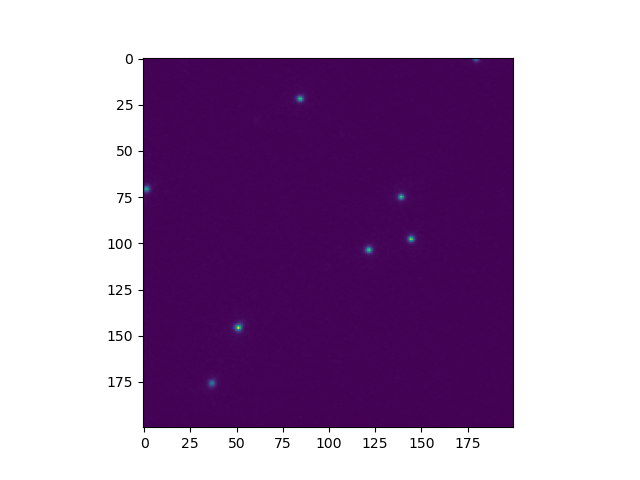

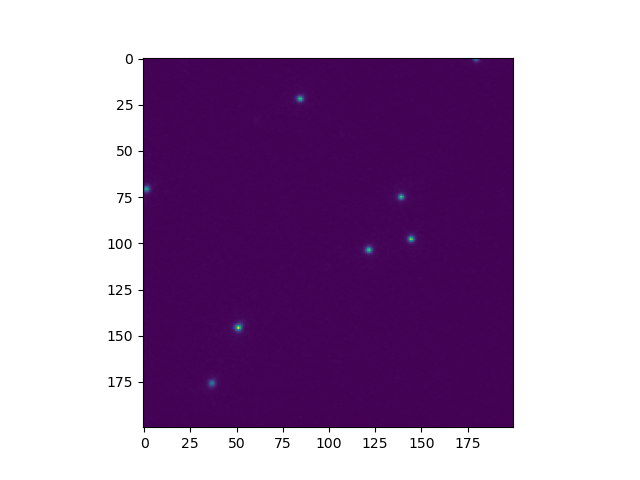

In [7]:
 
beads_pth = "20230623_default_settings/"
rbnames = sorted(glob(f'{beads_pth}*.tif'))
roi_rb = roi.ROI((144, 19), size=(200, 200))
roi_bb = roi.ROI((179, 284), size=(200, 200))#roi_r.size)
imrb=[pims.open(n)[0] for n in rbnames]
im_rb = [roi_rb(i) for i in imrb]
im_bb = [roi_bb(i) for i in imrb]

fig, ax=plt.subplots()
ax.imshow(im_bb[0])
fig.canvas

In [8]:

loc_rb_ui = nbui.Locator()
loc_rb_imsel = nbui.ImageSelector({n: [i] for n, i in zip(rbnames, im_rb)})
loc_rb_imsel.observe(imchange, "output")
imchange()
loc_rb_ui.image_display.auto_scale()
ipywidgets.VBox([loc_rb_imsel, loc_rb_ui])

/home/bomberman/miniconda3/lib/python3.11/site-packages/sdt/nbui/locator.py:306: UserWarning: Turning off matplotlib's interactive mode as it is not compatible with this.
  warnings.warn("Turning off matplotlib's interactive mode as it "


In [9]:


loc_bb_ui = nbui.Locator()
loc_bb_imsel = nbui.ImageSelector({n: [i] for n, i in zip(rbnames, im_bb)})
loc_bb_imsel.observe(imchangeb, "output")
imchangeb()
loc_bb_ui.image_display.auto_scale()
ipywidgets.VBox([loc_bb_imsel, loc_bb_ui])

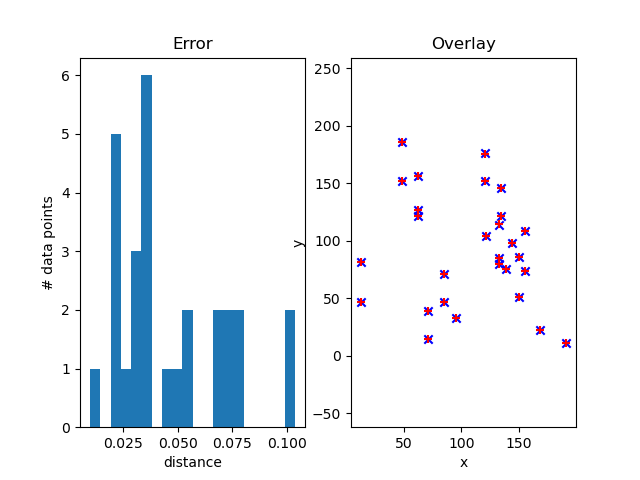

In [10]:
# batch_func for multiple images, loc_func for single frame
beads_rb = [loc_rb_ui.locate_func(i, **loc_rb_ui.options) for i in im_rb]
beads_bb = [loc_bb_ui.locate_func(i, **loc_bb_ui.options) for i in im_bb]

regb = multicolor.Registrator(beads_rb, beads_bb)
# old reg = chromatic.Corrector(beads_b, beads_r)
regb.determine_parameters()  # flip_axes only for old version


fig, ax = plt.subplots(1, 2)
regb.test(ax=ax)
fig.canvas

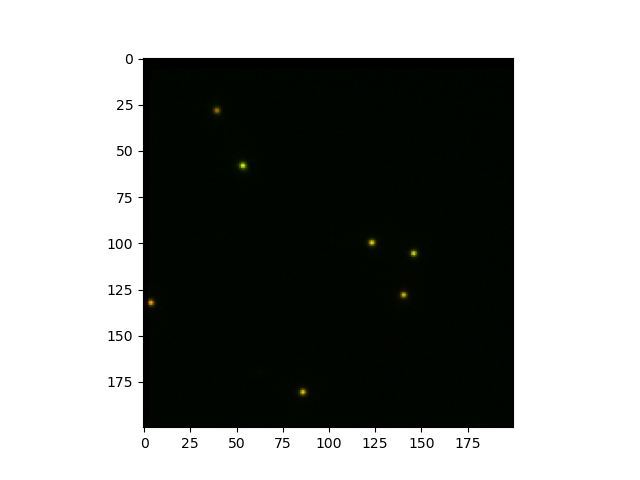

In [11]:
im_bb_corr = regb(im_bb[0], channel=2)
rgb = np.array([image.fill_gamut(im_rb[0], dtype=np.uint8),
                image.fill_gamut(im_bb_corr, dtype=np.uint8),
                np.zeros_like(im_bb_corr, dtype=np.uint8)])
rgb = np.transpose(rgb, [1, 2, 0])

r = np.array([image.fill_gamut(im_rb[0], dtype=np.uint8),
                np.zeros_like(im_rb[0], dtype=np.uint8),
                np.zeros_like(im_rb[0], dtype=np.uint8)])
r = np.transpose(r, [1, 2, 0])

g = np.array([np.zeros_like(im_bb_corr, dtype=np.uint8),
                image.fill_gamut(im_bb_corr, dtype=np.uint8),
                np.zeros_like(im_bb_corr, dtype=np.uint8)])
g = np.transpose(g, [1, 2, 0])



fig, ax = plt.subplots()

#ax[0].imshow(r)
#ax[1].imshow(g)
ax.imshow(rgb)

fig.canvas

In [12]:
# save the beads parameters
with open(f"{beads_pth}Registration.yaml", "w") as f:
    sdt.io.yaml.safe_dump(regb, f)
    

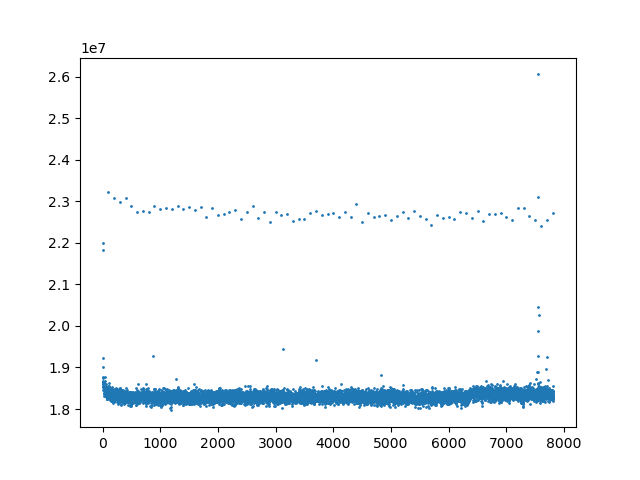

In [13]:
# For the Drift correction:
# load bead drift parameters
beads_pth = "20230623_default_settings/"
with open(f"{beads_pth}Registration.yaml", "r") as f:
    regb = sdt.io.yaml.safe_load(f)

beads = [pims.open("out.tif")]

#define bead roi
roib = roi.ROI((128, 256), size=(256, 256))
beads[0]=roib(beads[0])

#identify bead images based on different intensity
bds=np.zeros(len(beads[0]))
for i in range(len(beads[0])):
    bds[i]=np.sum(beads[0][i])
    
fig, ax=plt.subplots()
ax.scatter(np.linspace(0, len(beads[0])-1, len(beads[0])), bds, s=1)
fig.canvas

In [14]:
#filter the beads:
bs=beads[0][bds>1.7580e7]

#locator app
def imchange(change=None):
    loc_b_ui.input = loc_b_imsel.output

loc_b_ui = nbui.Locator()
loc_b_imsel = nbui.ImageSelector({n: i for n, i in zip(filenames, [bs])})
loc_b_imsel.observe(imchange, "output")
imchange()
loc_b_ui.image_display.auto_scale()
ipywidgets.VBox([loc_b_imsel, loc_b_ui])

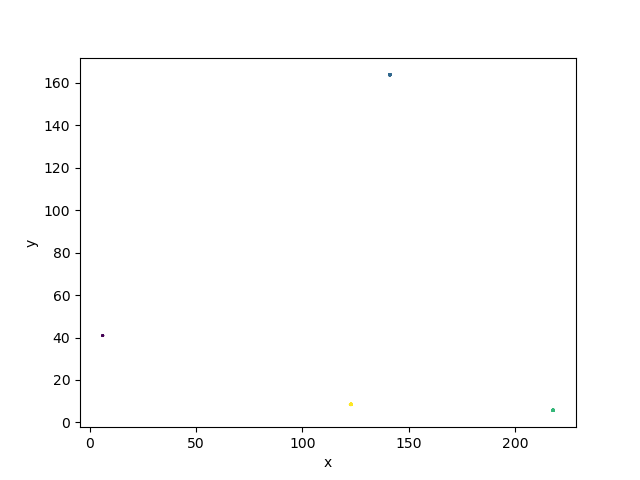

In [15]:
# 2D localization
# batch_func for multiple images, locate_func for single frame
bloc = [loc_b_ui.batch_func(i, **loc_b_ui.options) for i in [bs]]
# chromatic correction/channel registration needs to be added
#bloc[0]['y']=-bloc[0]['y']
bloc[0]= regb(bloc[0], channel=2)

from sklearn.cluster import DBSCAN
# cluster the data into five clusters
x = bloc[0].loc[:, ['x','y']].values
dbscan = DBSCAN(eps =2, min_samples = 20).fit(x) # fitting the model
# min_samples = 10000 if beads are on for that long, shorter if we only have beads every 100th frame
# default: dbscan = DBSCAN(eps = 1, min_samples = 50).fit(x) # fitting the model
labels = dbscan.labels_ # getting the labels
# Plot the clusters

bloc[0]['cluster']=labels
#bg_locs=locs[locs['cluster']<0]
be=bloc[0][bloc[0]['cluster']>=0]

fig, ax=plt.subplots()
plt.scatter(x[:, 0], x[:,1], c = labels, s=1) # plotting the clusters
plt.xlabel("x") # X-axis label
plt.ylabel("y") # Y-axis label
plt.show() # showing the plot

# Main part

In [16]:
k=0
defocus = matching_files[k][:-4]
pthpsf = matching_paths[k]
prl = loadmat(pthpsf) # load datafile from matlab app

psf = prl["PSF"][0,0][8] # load the psf 
nx_psf,ny_psf,nz_psf = psf.shape # dimensions of the psf
os = prl["PSF"][0,0][7][0,0] 
QE = prl["PSF"][0,0][9][0,0][2][0,0] 
baseline = prl["PSF"][0,0][9][0,0][3][0,0]
amp = prl["PSF"][0,0][9][0,0][4][0,0]

# load preloc parameters as pkl
with open(f'{directory}/preloc_par_{defocus}.pkl', 'rb') as file:
    loc_r_ui = pickle.load(file)

preliminary_results = pd.read_csv(f'preloc_results_{defocus}.csv')

df=pd.DataFrame.from_dict(preliminary_results)
fresults=df[df['z [nm]']>-300].copy()
frame=np.array([])
dx=np.array([])
dy=np.array([])
for i in set(be['cluster']):
    b=be[be['cluster']==i].copy()
    frame=np.concatenate((frame, b['frame'].values))
    dx=np.concatenate((dx, (b['x']-np.mean(b['x'].values[:10])).values))
    dy=np.concatenate((dy, (b['y']-np.mean(b['y'].values[:10])).values))
drift=pd.DataFrame()
drift['frame']=frame
drift['dx']=dx
drift['dy']=dy
drift['dig']=np.digitize(drift['frame'], bins=np.arange(0, 30000, 500))

# save the drift for the ROI:
drift.to_csv(f'drift_sample_16_1_1_p1.csv')

fresults['dig']=np.digitize(fresults['frame'], bins=np.arange(0, 30000, 500))
av_drift=drift.groupby(drift['dig']).mean()

fresults['x_cor']=fresults['x [nm]'].copy()
fresults['y_cor']=fresults['y [nm]'].copy()

ux = 1e9*prl["PSF"][0,0][5]   #nm
uz = 1e9*prl["PSF"][0,0][6]   #nm
ux,uz = ux[0,0],uz[0,0]
for i in set(fresults['dig']):
    #print(i)
    avdx=av_drift[av_drift.index==i]['dx'].values 
    avdy=av_drift[av_drift.index==i]['dy'].values
    a=fresults[fresults['dig']==i]['x_cor']-avdx[0]*ux
    b=fresults[fresults['dig']==i]['y_cor']-avdy[0]*ux
    fresults.loc[fresults['dig']==i, 'x_cor']=a.values
    fresults.loc[fresults['dig']==i, 'y_cor']=b.values
fresults.to_csv(f'{pth}/results_{defocus}.csv')

In [17]:
fig,ax = plt.subplots()
ax.scatter(fresults['frame'],fresults['x_cor'])

In [18]:
fig,ax = plt.subplots()
ax.hist(drift['dig'])

(array([30., 15., 30., 15., 30., 15., 30., 15., 30., 27.]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <BarContainer object of 10 artists>)